In [1]:
#### Classification of images of handwritten digits
#### Convolutional neural network using PyTorch for classifying the MNIST dataset
#### by Siddharth Sourabh Sahu
#### for the course Deep Learning - Spring, 2021
#### Uppsala University

In [2]:
### Import packages 
import numpy as np
import matplotlib.pyplot as plt
import imageio
import glob
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time

In [3]:
### Import the MNIST dataset from png images
def load_mnist():
     
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("C:/Users/sahus/Documents/Deep Learning assmt/MNIST/MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("C:/Users/sahus/Documents/Deep Learning assmt/MNIST/MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train = np.array(train_images).reshape(-1,1,28,28)/255.0
    Y_train = np.array(train_labels)
    X_test = np.array(test_images).reshape(-1,1,28,28)/255.0
    Y_test = np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [4]:
# create mini-batches from the dataset
def create_mini_batches(x, y, i, n_b):

    x_b = x[(int)(i*n_b):(i+1)*n_b,:,:,:]
    y_b = y[(int)(i*n_b):(i+1)*n_b,:]
    
    return x_b, y_b

In [5]:
# Load MNIST data
X_train, Y_train, X_test, Y_test = load_mnist()
# extract shape of the training and test data 
n, chn, k, k = np.shape(X_train)
n, M = np.shape(Y_train)
n_t, chn, k, k = np.shape(X_test)
n_t, M = np.shape(Y_test)
# n,n_t: no. of train and test examples, chn: no. of input channels, k: no. of pixels per image; M: number of classes

In [6]:
# convert the numpy arrays to tensors
x_train = torch.FloatTensor(X_train.tolist())
y_train = torch.LongTensor(Y_train.tolist())
x_test = torch.FloatTensor(X_test.tolist())
y_test = torch.LongTensor(Y_test.tolist())

In [25]:
# define parameters

epochs = 10             # epochs
n_b = 100               # mini-batch size
learning_rate = 0.05    # learning rate

In [26]:
class ConvoNN(nn.Module):
    
    def __init__(self):
        super(ConvoNN, self).__init__()
        self.CNN1 = nn.Conv2d(in_channels=1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'zeros')
        self.relu1 = nn.ReLU()
        self.MaxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.CNN2 = nn.Conv2d(in_channels=8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'zeros')
        self.relu2 = nn.ReLU()
        self.MaxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.CNN3 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'zeros')
        self.relu3 = nn.ReLU()
        self.FC = nn.Linear(32*7*7, M)

    def forward(self, x):
        # set 1
        x = self.CNN1(x)
        x = self.relu1(x)
        x = self.MaxPool1(x)

        # set2
        x = self.CNN2(x)
        x = self.relu2(x)
        x = self.MaxPool2(x)

        #set 3
        x = self.CNN3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)      # flatten for fully connected NN
        x = self.FC(x)

        return F.log_softmax(x, dim=1)

net = ConvoNN()
print(net)

ConvoNN(
  (CNN1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (FC): Linear(in_features=1568, out_features=10, bias=True)
)


In [27]:
# define how the weights are optimized: use stochastic gradient descent with Adam method
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# define loss function as the cross entropy loss
loss_func = nn.CrossEntropyLoss()

In [28]:
# net_out = net(x_train)
# print(net_out.size())


In [29]:
loss_list = []
CA_list = []
CA_test_list = []

# start_time = time.time()

for e in range(epochs):
    
    # permutation of the training data
    permute = np.random.permutation(n)
    x_perm = x_train[permute]
    y_perm = y_train[permute]

    # for i in range(0, n, batch_size):
    for i in range((int)((n/n_b)-1)):
        # create mini-batches
        x_mini, y_mini = create_mini_batches(x_perm, y_perm, i, n_b)
        
        # x_var = Variable(x_mini)
        # y_var = Variable(y_mini)
        optimizer.zero_grad()
        net_out = net(x_mini)
        # convert one-hot encoding to indices
        y_index = np.argmax(y_mini, axis=1)
        loss = loss_func(net_out, y_index)
        loss.backward()
        optimizer.step()
        # calculate classification accuracy
        max_indices = np.argmax(net_out.detach().numpy(), axis=1)
        correct_matches = np.zeros(n_b)
        correct_matches[y_index.numpy() == max_indices] = 1
        CA = np.sum(correct_matches)/n_b
        loss_list.append(loss.detach().numpy())
        CA_list.append(CA)
        # evaluate on testing data
        # net_out = net(x_test)
        # y_index = np.argmax(y_test, axis=1)
        # max_indices = np.argmax(net_out.detach().numpy(), axis=1)
        # correct_matches = np.zeros(n_t)
        # correct_matches[y_index.numpy() == max_indices] = 1
        # CA = np.sum(correct_matches)/n_t
        # CA_test_list.append(CA)

    print('Epoch: {} - Loss: {:.6f}'.format(e, loss))
# print('---Execution time: %s s---'%(time.time()-start_time))

Epoch: 0 - Loss: 0.048367
Epoch: 1 - Loss: 0.054123
Epoch: 2 - Loss: 0.041720
Epoch: 3 - Loss: 0.099047
Epoch: 4 - Loss: 0.029736
Epoch: 5 - Loss: 0.009327
Epoch: 6 - Loss: 0.077672
Epoch: 7 - Loss: 0.010445
Epoch: 8 - Loss: 0.009987
Epoch: 9 - Loss: 0.014728


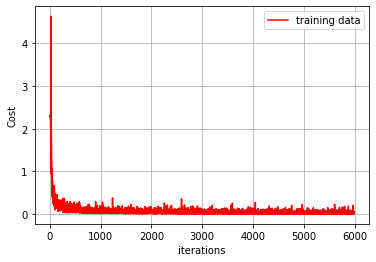

In [30]:
# Cost vs iterations
%matplotlib inline
# %matplotlib widget
# cost = np.array(cost)
# cost_test = np.array(cost_test)
plt.figure(1)
plt.plot(loss_list, 'r', label = 'training data')
# plt.plot(cost_test, 'b.', label = 'testing data')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

In [31]:
%matplotlib widget
# Classification accuracy vs iterations
plt.figure(2)
plt.plot(CA_list, 'r-', label = 'training data')
# plt.plot(CA_test_list, 'b-', label = 'testing data')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Classification Accuracy')
plt.grid(True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [39]:
# Confusion Matrix
net_out = net(x_test)
y_index = np.argmax(y_test, axis=1)
max_indices = np.argmax(net_out.detach().numpy(), axis=1)
correct_matches = np.zeros(n_t)
correct_matches[y_index.numpy() == max_indices] = 1
CA = np.sum(correct_matches)/n_t
CA_test_list.append(CA)


In [40]:
confusion_matrix = np.zeros((10,10))
np.add.at(confusion_matrix, [y_index.numpy(), max_indices], 1)
print(confusion_matrix)

[[9.770e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 1.130e+03 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.025e+03 1.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 1.002e+03 0.000e+00 3.000e+00 0.000e+00
  3.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.750e+02 0.000e+00 0.000e+00
  1.000e+00 0.000e+00 6.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 6.000e+00 0.000e+00 8.810e+02 2.000e+00
  0.000e+00 0.000e+00 1.000e+00]
 [3.000e+00 3.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00 9.460e+02
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 7.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.014e+03 1.000e+00 3.000e+00]
 [5.000e+00 2.000e+00 4.000e+00 3.000e+00 1.000e+00 1.000e+00 2.000e+00
  2.000e+00 9.490e+02 5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 3.000e+00 8.000e+00 2.0